In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from os import path
from scipy.signal import resample
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
mpl.style.use('seaborn-notebook')
%matplotlib inline
#sorted(mpl.style.available)


#adding local modules
import sys
module_path = path.abspath(path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from preprocess.biodarw_feature_extraction import extract_residues, extract_radio
from utils import load_biodarw

# setting up variables
doc_path = "/data/elekin/doc"
coefficients=17


# radius or residues
feature='radius'

# if features is residues ''<coefficients>_' for example '17_' otherwhise ''
coefficients= '' if feature == 'radius' else '17'

%matplotlib inline

In [2]:
score = 'accuracy'

#this data has been previously processed by airflow
features = pd.read_csv("/data/elekin/data/results/handwriting/tmp/windowed_data_augmentation_{}_{}_20220911.csv".format(feature, coefficients)) #TODO automate
features = features.set_index(features.columns[0]).sort_index()
print("Loaded data from CSV")
features.head(5)

Loaded data from CSV


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
C01_1,0.000000,139.620900,12.303175,74.603526,11.278530,53.647830,16.991655,35.022860,12.339670,32.053996,...,20.696314,20.918954,24.735220,24.312920,22.370285,23.583166,28.246445,30.232018,28.765377,30.611842
C01_1,139.620900,12.303175,74.603526,11.278530,53.647830,16.991655,35.022860,12.339670,32.053996,18.735860,...,20.918954,24.735220,24.312920,22.370285,23.583166,28.246445,30.232018,28.765377,30.611842,35.592459
C01_1,12.303175,74.603526,11.278530,53.647830,16.991655,35.022860,12.339670,32.053996,18.735860,20.204644,...,24.735220,24.312920,22.370285,23.583166,28.246445,30.232018,28.765377,30.611842,35.592459,38.775607
C01_1,74.603526,11.278530,53.647830,16.991655,35.022860,12.339670,32.053996,18.735860,20.204644,13.337827,...,24.312920,22.370285,23.583166,28.246445,30.232018,28.765377,30.611842,35.592459,38.775607,37.805279
C01_1,11.278530,53.647830,16.991655,35.022860,12.339670,32.053996,18.735860,20.204644,13.337827,22.690049,...,22.370285,23.583166,28.246445,30.232018,28.765377,30.611842,35.592459,38.775607,37.805279,39.197084


Loading labels based on clinic, residues and features from residues.


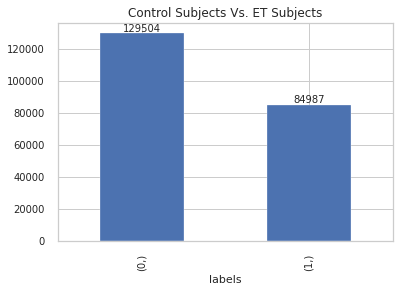

In [3]:
y = pd.read_csv("/data/elekin/data/results/handwriting/tmp/windowed_data_augmentation_{}_{}_20220911_labels.csv".format(feature, coefficients)) #TODO automate
y = y.set_index(y.columns[0]).sort_index()
ax = y.value_counts().plot.bar(title='Control Subjects Vs. ET Subjects', x='counts')
_ = ax.bar_label(ax.containers[0])

Verify that the data calculated with airflow is correct

<AxesSubplot:>

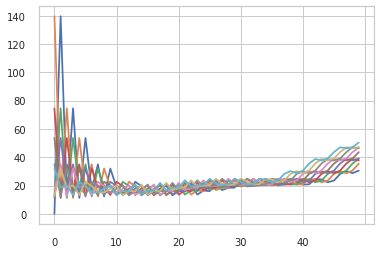

In [4]:
features.loc['C01_1'].iloc[:10].T.plot(legend=False)

In [5]:
features.loc['C01_1'].shape

(4047, 50)

<AxesSubplot:>

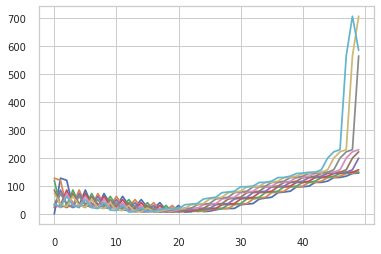

In [6]:
features.loc['T027'].iloc[:10].T.plot(legend=False)

In [7]:
features.shape,y.shape

((214491, 50), (214491, 1))

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
random_state = 0

X_train=features.values
y_train=y.values.ravel()

In [9]:
# Reduce dimension with LDA
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=1))
lda.fit(X_train, y_train)
X_train_lda=lda.transform(X_train)

In [10]:
df_lda=pd.DataFrame(X_train_lda, columns=["LDA1"])#temblor
#df_lda=pd.DataFrame(X_train_lda, columns=["component1", "component2"])#level
df_lda["labels"]=y_train
df_lda.head()

,LDA1,labels
0,-1.365164,0
1,-1.317675,0
2,-1.362442,0
3,-1.346247,0
4,-1.363706,0


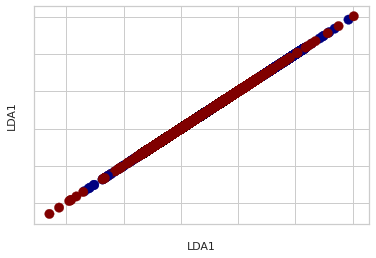

In [11]:
ax = df_lda.plot.scatter(x="LDA1", y="LDA1", c="labels", cmap="jet", s=90, colorbar=False)
ax.xaxis.set_ticklabels([])
_ = ax.yaxis.set_ticklabels([])

In [12]:
# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(),
                    PCA(n_components=3, random_state=random_state))
# Fit the method's model
pca.fit(X_train, y_train)
X_train_pca=pca.transform(X_train)

In [13]:
df_pca=pd.DataFrame(X_train_pca, columns=["PCA0", "PCA1","PCA2"])
df_pca["labels"]=y_train.ravel()
df_pca.head()

,PCA0,PCA1,PCA2,labels
0,-9.648651,0.036112,0.025725,0
1,-9.645265,0.037607,0.032391,0
2,-9.654871,0.017368,0.015404,0
3,-9.652440,0.016425,0.018729,0
4,-9.655808,0.005834,0.011324,0


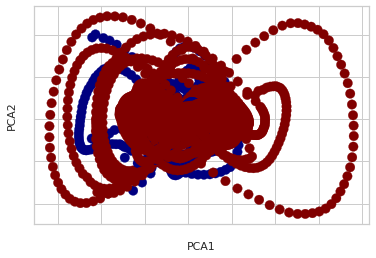

In [14]:
ax = df_pca.plot.scatter(x="PCA1", y="PCA2", c="labels", cmap="jet", s=90, colorbar=False)
ax.xaxis.set_ticklabels([])
_ = ax.yaxis.set_ticklabels([])

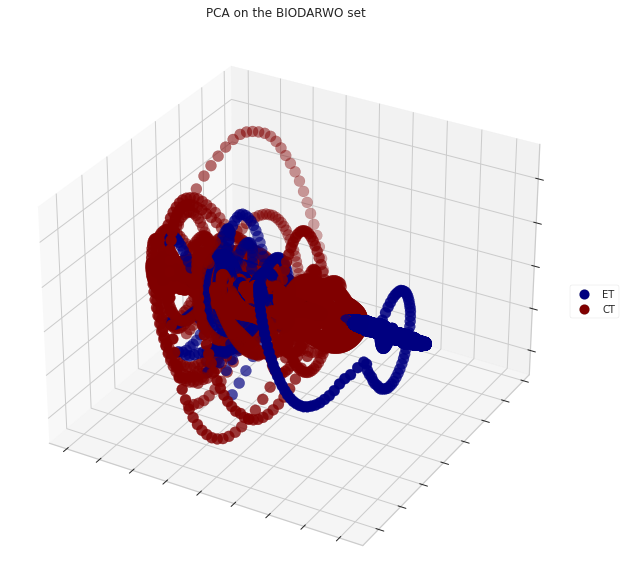

In [15]:
# Plot initialisation
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111, projection='3d')


sc=ax.scatter(df_pca['PCA0'], 
              df_pca['PCA1'], 
              df_pca['PCA2'], c=df_pca.labels, cmap="jet", s=120)
    
# label the axes
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_zlabel(None)
ax.set_title("PCA on the BIODARWO set")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

colors = [sc.cmap(sc.norm(i)) for i in [0.0, 1.0, 2.0]]

custom_lines = [plt.Line2D([],[], ls="", marker='.', 
                mec='k', mfc=c, mew=.1, ms=20) for c in colors]
import collections
legend = ['ET','CT']#temblor
ax.legend(custom_lines, legend, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

In [16]:
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report


score='accuracy'
X = X_train
y = y_train

loo = LeaveOneOut()

In [17]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X, y, test_size=0.33, random_state=38)
Counter(ys_train), Counter(ys_test)

(Counter({1: 57020, 0: 86688}), Counter({0: 42816, 1: 27967}))

$$ Accuracy: \frac{TP + TN}{TP + TN + FP + FN} $$ 

$$    Recall: \frac{TP}{TP + FN} $$

$$    Precision: \frac{TP}{TP + FP} $$

$$    Specifity: \frac{TN}{TN + FP} $$

Where TP, TN, FP, and FN are, respectively, the true positive, true negative, false positive and false negative values
of the confusion matrix. The positive case corresponds to the ET subjects while the negative case to the CT ones.

**Equations explained**

* Sensitivity/recall – how good a test is at detecting the positives. A test can cheat and maximize this by always returning “positive”. From the whole positive cases how many of them where properly detected.
* Specificity – how good a test is at avoiding false alarms. A test can cheat and maximize this by always returning “negative”.
* Precision – how many of the positively classified were relevant. A test can cheat and maximize this by only returning positive on one result it’s most confident in. 

The cheating is resolved by looking at both relevant metrics instead of just one. E.g. the cheating 100% sensitivity that always says “positive” has 0% specificity.


Hold hout validation

Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

### RandomForest

Leaving one out validation

In [ ]:
clf =  make_pipeline(StandardScaler(),RandomForestClassifier(n_estimators=100, random_state=38))

cv = cross_validate(clf, X, y, cv=loo, scoring=score, return_train_score=True, n_jobs=-1)

print("CV train score RandomForest: {}".format(cv['train_score'].mean()))
print("CV test score RandomForest: {}".format(cv['test_score'].mean()))

Holdout validation

In [ ]:
clf.fit(Xs_train, ys_train)
predictions = clf.predict(Xs_test)
#cm = confusion_matrix(ys_test, predictions, labels=clf.classes_)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
#disp.plot(cmap=plt.cm.Blues)
#_=plt.axis('off')

In [ ]:
report = classification_report(ys_test, predictions, digits=4, target_names=['Negative','Positive'], output_dict=True)
report = classification_report(ys_test, predictions, digits=4, target_names=['Negative','Positive'], output_dict=True)
report['loo']= {}
report['loo']['acc']=cv['train_score'].mean()
report['loo']['val_acc']=cv['test_score'].mean()
reports['randomforest'] = report

### KNN-5

Leaving one out validation

In [ ]:
clf = clf =  make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='euclidean'))

cv = cross_validate(clf, X, y, cv=loo, scoring=score, return_train_score=True, n_jobs=-1)

print("CV train score knn: {}".format(cv['train_score'].mean()))
print("CV test score knn: {}".format(cv['test_score'].mean()))

Holdout validation

In [ ]:
clf.fit(Xs_train, ys_train)
predictions = clf.predict(Xs_test)
#cm = confusion_matrix(ys_test, predictions, labels=clf.classes_)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
#disp.plot(cmap=plt.cm.Blues)
#_=plt.axis('off')

In [ ]:
report = classification_report(ys_test, predictions, digits=4, target_names=['Negative','Positive'], output_dict=True)
report['loo']= {}
report['loo']['acc']=cv['train_score'].mean()
report['loo']['val_acc']=cv['test_score'].mean()
reports['knn'] = report

### LDA

Leaving one out validation

In [ ]:
clf =  make_pipeline(StandardScaler(),LDA())

cv = cross_validate(clf, X, y, cv=loo, scoring=score, return_train_score=True, n_jobs=-1)

print("CV train score LDA: {}".format(cv['train_score'].mean()))
print("CV test score LDA: {}".format(cv['test_score'].mean()))

Holdout validation

In [ ]:
clf.fit(Xs_train, ys_train)
predictions = clf.predict(Xs_test)
#cm = confusion_matrix(ys_test, predictions, labels=clf.classes_)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
#disp.plot(cmap=plt.cm.Blues)
#_=plt.axis('off')

In [ ]:
report = classification_report(ys_test, predictions, digits=4, target_names=['Negative','Positive'], output_dict=True)
report['loo']= {}
report['loo']['acc']=cv['train_score'].mean()
report['loo']['val_acc']=cv['test_score'].mean()
reports['lda'] = report

### SVM-rbf

Leaving one out validation

In [ ]:
reports = dict()
# predictive model
clf = clf =  make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma=0.2, C=10**3))

In [ ]:
cv = cross_validate(clf, X, y, cv=loo, scoring=score, return_train_score=True, n_jobs=-1)
print("CV train score svm: {}".format(cv['train_score'].mean()))
print("CV test score svm: {}".format(cv['test_score'].mean()))

In [ ]:
clf.fit(Xs_train, ys_train)
predictions = clf.predict(Xs_test)
#cm = confusion_matrix(ys_test, predictions, labels=clf.classes_)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
#disp.plot(cmap=plt.cm.Blues)
#_=plt.axis('off')

In [ ]:
report = classification_report(ys_test, predictions, digits=4, target_names=['Negative','Positive'], output_dict=True)
report['loo']= {}
report['loo']['acc']=cv['train_score'].mean()
report['loo']['val_acc']=cv['test_score'].mean()
reports['svm-rbf'] = report

In [ ]:
for key in reports:
    print('{}'.format(key))

In [ ]:
for key in reports:
    print('{}'.format(reports[key]['loo']['val_acc']))

In [ ]:
for key in reports:
    print('{}'.format(reports[key]['accuracy']))

In [ ]:
for key in reports:
    print('{}'.format(reports[key]['Positive']['recall']))

In [ ]:
for key in reports:
    print('{}'.format(reports[key]['Negative']['recall']))

In [ ]:
for key in reports:
    print('{}'.format(reports[key]['Positive']['precision']))

In [ ]:
for key in reports:
    print('{}'.format(reports[key]['Negative']['precision']))

In [ ]:
for key in reports:
    print('{}'.format(reports[key]['Positive']['f1-score']))

In [ ]:
for key in reports:
    print('{}'.format(reports[key]['Negative']['f1-score']))